In [1]:
# Import required libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

# Set up matplotlib for better visualization in notebook
plt.rcParams['figure.figsize'] = [12, 8]

# Define global functions
def merge_similar_lines(lines, min_distance=15, min_angle=15):
    if lines is None:
        return None

    merged_lines = []
    used = set()

    for i, line1 in enumerate(lines):
        if i in used:
            continue

        x1, y1, x2, y2 = line1[0]
        angle1 = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

        current_group = [line1[0]]
        used.add(i)

        for j, line2 in enumerate(lines):
            if j in used:
                continue

            x3, y3, x4, y4 = line2[0]
            angle2 = np.arctan2(y4 - y3, x4 - x3) * 180 / np.pi

            angle_diff = abs(angle1 - angle2) % 180
            if angle_diff > 90:
                angle_diff = 180 - angle_diff

            dist = min(np.sqrt((x1-x3)**2 + (y1-y3)**2),
                      np.sqrt((x1-x4)**2 + (y1-y4)**2),
                      np.sqrt((x2-x3)**2 + (y2-y3)**2),
                      np.sqrt((x2-x4)**2 + (y2-y4)**2))

            if angle_diff < min_angle and dist < min_distance:
                current_group.append(line2[0])
                used.add(j)

        if current_group:
            points = np.array(current_group)
            x1 = points[:, 0].mean()
            y1 = points[:, 1].mean()
            x2 = points[:, 2].mean()
            y2 = points[:, 3].mean()
            merged_lines.append(np.array([[int(x1), int(y1), int(x2), int(y2)]]))

    return np.array(merged_lines)


def check_intersection(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    # Calculate denominator
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # If lines are parallel
    if abs(denom) < 1e-5:
        return False

    # Calculate intersection point
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    # Check if intersection is well within the line segments
    buffer = 0.2  # Increased buffer
    return (buffer <= t <= 1-buffer) and (buffer <= u <= 1-buffer)


def filter_non_intersecting_lines(lines):
    if lines is None:
        return None

    # First pass: merge very close parallel lines
    merged = merge_similar_lines(lines, min_distance=20, min_angle=20)

    # Second pass: find truly intersecting lines
    non_intersecting = []
    used = set()

    for i, line1 in enumerate(merged):
        if i in used:
            continue

        intersects = False
        for j, line2 in enumerate(merged):
            if i != j and check_intersection(line1, line2):
                intersects = True
                used.add(j)  # Mark both intersecting lines as used
                break

        if not intersects:
            non_intersecting.append(line1)

    return np.array(non_intersecting) if non_intersecting else None


def detect_objects(image):
    # Convert to grayscale and apply preprocessing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process each contour
    objects = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            center = (
                int(M["m10"] / M["m00"]),  # cX
                int(M["m01"] / M["m00"])   # cY
            )
        else:
            center = None

        object_info = {
            'contour': contour,
            'center': center,
            'area': cv2.contourArea(contour)
        }
        objects.append(object_info)

    return objects, thresh


def draw_object_index(image, objects):
    result = image.copy()

    for i, obj in enumerate(objects):
        # Generate random color for this contour
        color = (np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255))

        # Draw the contour
        cv2.drawContours(result, [obj['contour']], -1, color, 2)

        # Draw center and label if center exists
        if obj['center']:
            cv2.circle(result, obj['center'], 5, (255, 255, 255), -1)
            cv2.putText(result,
                       f"Object {i+1}",
                       (obj['center'][0] - 100, obj['center'][1] - 20),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       1,
                       (255, 0, 0),
                       2)

    return result


def classify_shapes(objects, circularity_threshold=0.85):
    circles = []
    other_shapes = []

    for obj in objects:
        contour = obj['contour']
        area = obj['area']
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:
            circles.append(obj)
        else:
            other_shapes.append(obj)

    return circles, other_shapes


def draw_classified_shapes(image, circles, other_shapes):
    result = image.copy()

    # Draw circles in green
    for i, obj in enumerate(circles):
        cv2.drawContours(result, [obj['contour']], -1, (0, 255, 0), 2)
        if obj['center']:
            cX, cY = obj['center']
            cv2.circle(result, (cX, cY), 5, (0, 0, 0), -1)
            cv2.putText(result, f"Circle {i+1}", (cX - 20, cY - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Draw other shapes in red
    for i, obj in enumerate(other_shapes):
        cv2.drawContours(result, [obj['contour']], -1, (0, 0, 255), 2)
        if obj['center']:
            cX, cY = obj['center']
            cv2.circle(result, (cX, cY), 5, (0, 0, 0), -1)
            cv2.putText(result, f"Shape {i+1}", (cX - 20, cY - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    return result


def sort_circles_by_size(circles):
    if not circles:
        return None, None, None

    # Sort circles by area
    sorted_circles = sorted(circles, key=lambda x: x['area'])

    return (
        sorted_circles[0],
        sorted_circles[len(sorted_circles) // 2],
        sorted_circles[-1]
    )


def detect_lines(image, obj, thresh_image, params):
    # Get the contour from the circle object
    contour = obj['contour']

    # Create circle mask
    mask = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    cv2.drawContours(mask, [contour], -1, (255), -1)

    # Apply mask to thresholded image
    masked_image = cv2.bitwise_and(thresh_image, thresh_image, mask=mask)

    # Edge detection with erosion
    edges = cv2.Canny(masked_image, 50, 150, apertureSize=3)
    kernel = np.ones((7,7), np.uint8)
    inner_mask = cv2.erode(mask, kernel, iterations=4)
    edges = cv2.bitwise_and(edges, edges, mask=inner_mask)

    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, **params)

    # Merge similar lines
    merged_lines = merge_similar_lines(lines, min_distance=12, min_angle=10)

    return masked_image, merged_lines


def draw_lines(image, obj, lines, swap_colors=False, convert_rgb=True):
    result = image.copy()

    # Draw circle in green
    cv2.drawContours(result, [obj['contour']], -1, (0, 255, 0), 2)

    # Draw lines in red or blue depending on swap_colors
    line_color = (0, 0, 255) if not swap_colors else (255, 0, 0)  # BGR format
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), line_color, 2)

    # Convert to RGB only at the end if requested
    if convert_rgb:
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result


def detect_non_intersecting_lines(image, obj, thresh_image, params):
    # Get the contour from the circle object
    contour = obj['contour']

    # Create circle mask
    mask = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    cv2.drawContours(mask, [contour], -1, (255), -1)

    # Apply mask to thresholded image
    masked_image = cv2.bitwise_and(thresh_image, thresh_image, mask=mask)

    # Edge detection with erosion
    edges = cv2.Canny(masked_image, 50, 150, apertureSize=3)
    kernel = np.ones((7,7), np.uint8)
    inner_mask = cv2.erode(mask, kernel, iterations=4)
    edges = cv2.bitwise_and(edges, edges, mask=inner_mask)

    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, **params)

    # Merge similar lines with larger parameters for the largest circle
    merged_lines = merge_similar_lines(lines, min_distance=20, min_angle=20)

    # Filter out intersecting lines
    non_intersecting_lines = filter_non_intersecting_lines(merged_lines)

    return masked_image, non_intersecting_lines


def detect_intersecting_lines(image, obj, thresh_image, params):
    # Get the contour from the circle object
    contour = obj['contour']

    # Create circle mask
    mask = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    cv2.drawContours(mask, [contour], -1, (255), -1)

    # Apply mask to thresholded image
    masked_image = cv2.bitwise_and(thresh_image, thresh_image, mask=mask)

    # Edge detection with erosion
    edges = cv2.Canny(masked_image, 50, 150, apertureSize=3)
    kernel = np.ones((7,7), np.uint8)
    inner_mask = cv2.erode(mask, kernel, iterations=4)
    edges = cv2.bitwise_and(edges, edges, mask=inner_mask)

    # Detect lines with more selective parameters
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, **params)

    # Merge similar lines
    merged_lines = merge_similar_lines(lines)

    # Get non-intersecting lines
    non_intersecting = filter_non_intersecting_lines(merged_lines)

    # Keep only intersecting lines by removing non-intersecting ones
    if merged_lines is not None and non_intersecting is not None:
        intersecting_lines = [line for line in merged_lines if line not in non_intersecting]
        return masked_image, intersecting_lines

    return masked_image, None


def display_results(original_image, processed_image, result_image=None,
                    middle_title='Processed Image', title_suffix=''):
    plt.figure(figsize=(15, 5))

    # First image (always present)
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Second image (always present)
    plt.subplot(132)
    plt.imshow(processed_image, cmap='gray')
    plt.title(middle_title)
    plt.axis('off')

    # Third image (optional)
    plt.subplot(133)
    if result_image is not None:
        plt.imshow(result_image)
        plt.title(title_suffix)
    else:
        plt.gca().set_visible(False)  # Hide the third subplot if no image
    plt.axis('off')

    plt.show()

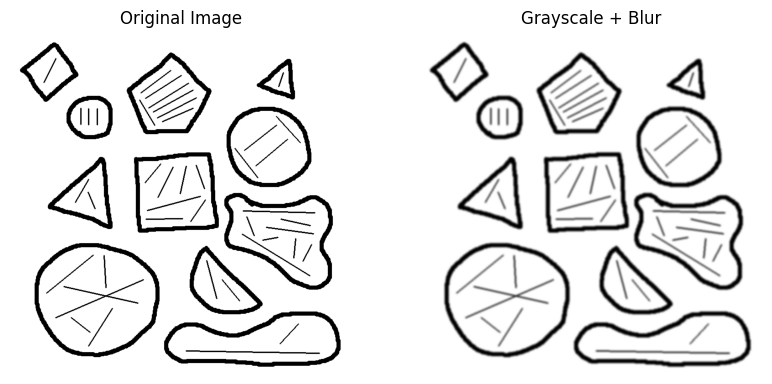

In [2]:
# For reference show Grayscale + Blur image
image = cv2.imread('image.png')

# Convert BGR to RGB for correct color display in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale (prolly not needed but we do this as a good practice)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Example print on how we are preprosessing the image
display_results(image_rgb, blurred, result_image=None, middle_title="Grayscale + Blur")

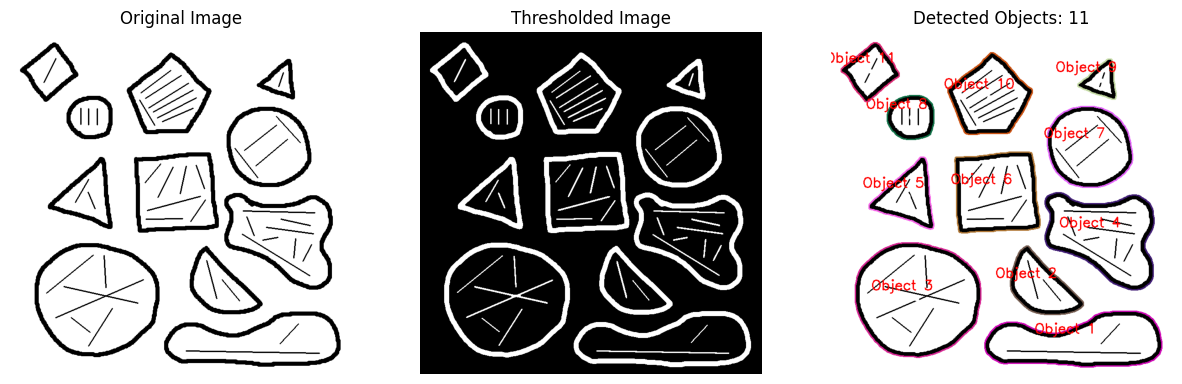

In [3]:
# Detect objects
objects, threshold_image = detect_objects(image)

result = draw_object_index(image, objects)

display_results(image,
                threshold_image,
                result,
                'Thresholded Image',
                f'Detected Objects: {len(objects)}')

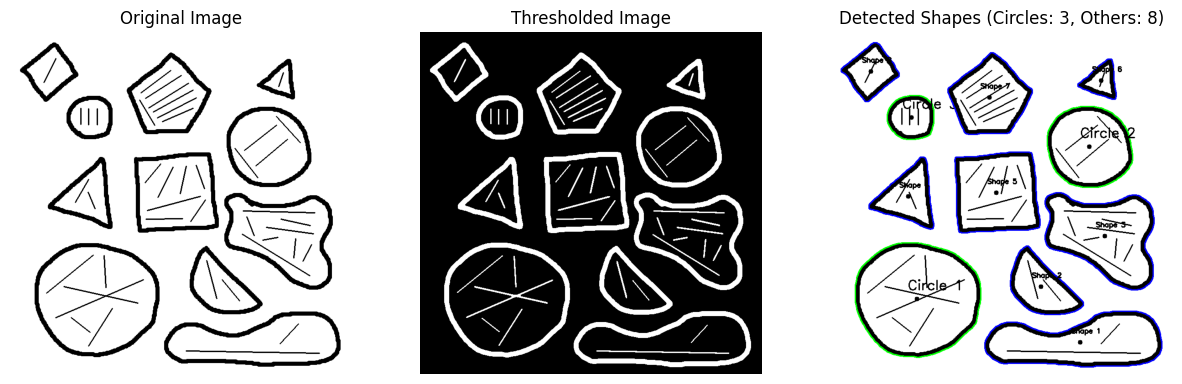

In [4]:
# Count circles

# reset result
result = image.copy()

# Lists to store circles and non-circles
circles = []
other_shapes = []

objects, threshold_image = detect_objects(image)

# Classify shapes
circles, other_shapes = classify_shapes(objects)

# Draw results
result = draw_classified_shapes(image, circles, other_shapes)

display_results(image,
                threshold_image,
                result,
                'Thresholded Image',
                f'Detected Shapes (Circles: {len(circles)}, Others: {len(other_shapes)})')

In [5]:
smallest, middle, largest = sort_circles_by_size(circles)

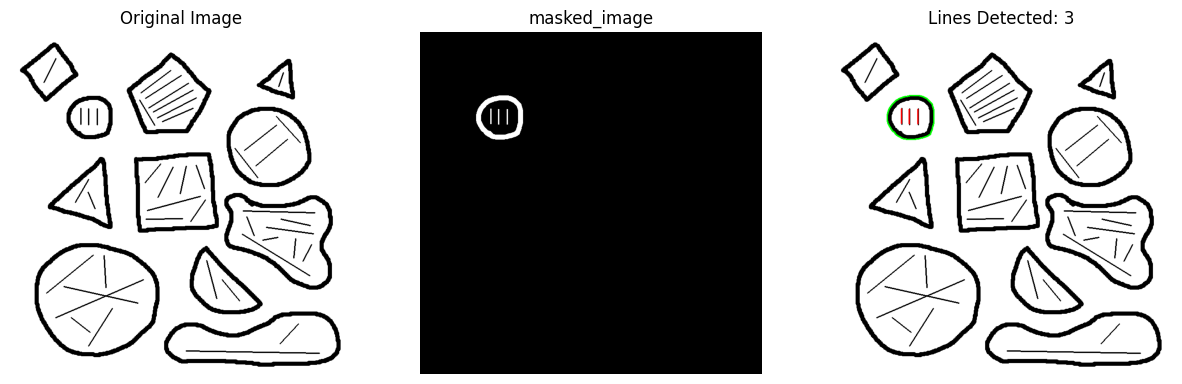

In [6]:
# Count lines in smallest circe
small_circle_params = {
    'threshold': 30,        # Minimum number of votes
    'minLineLength': 6,     # Minimum line length
    'maxLineGap': 3         # Maximum gap between line segments
}

# detecting and drawing the lines
if smallest is not None:
    masked_image, lines = detect_lines(
        image,
        smallest,
        threshold_image,
        small_circle_params
    )

    result = draw_lines(image, smallest, lines)

    display_results(image,
                   masked_image,
                   result,
                   'masked_image',
                   f'Lines Detected: {len(lines) if lines is not None else 0}')

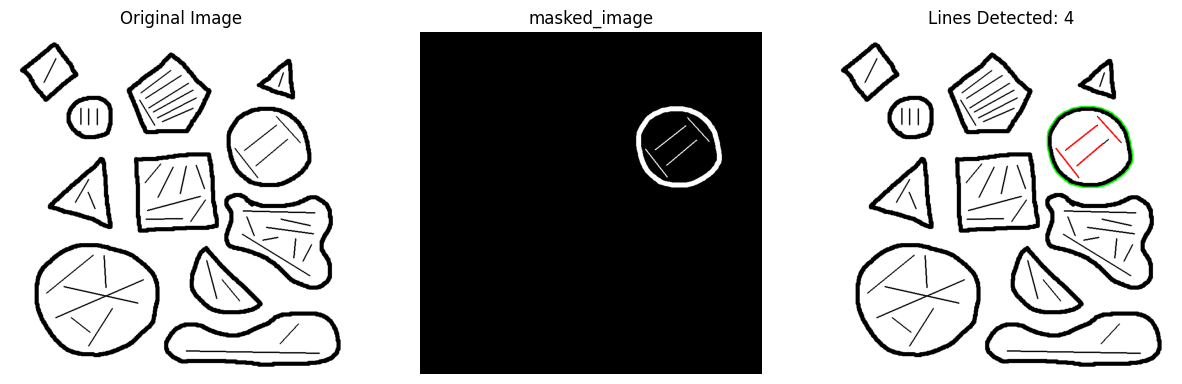

In [7]:
# Count lines in middle circle
middle_circle_params = {
    'threshold': 50,
    'minLineLength': 30,
    'maxLineGap': 7
}

# Detect and draw lines in middle circle
if middle is not None:
    masked_image, lines = detect_lines(
        image, middle, threshold_image, middle_circle_params
    )
    result = draw_lines(image, middle, lines)

    display_results(image,
                   masked_image,
                   result,
                   'masked_image',
                   f'Lines Detected: {len(lines) if lines is not None else 0}')

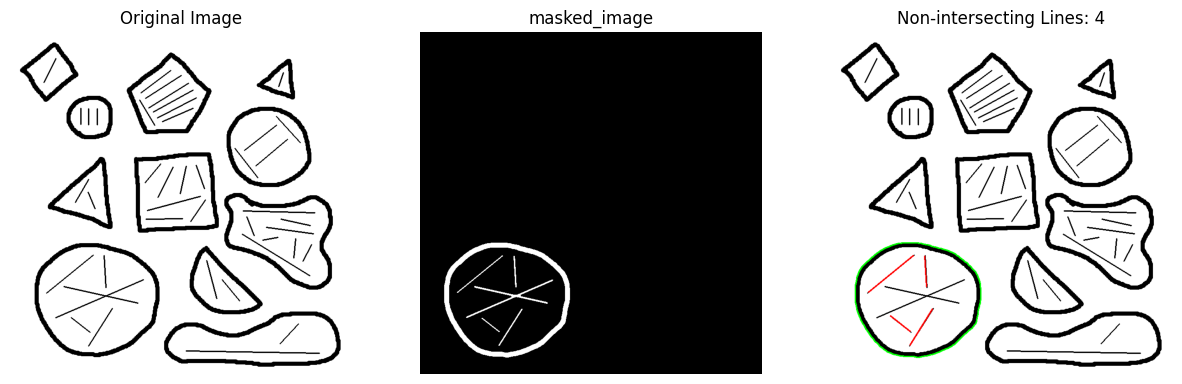

In [8]:
# Count nonintersecting lines in largest circle
non_intersecting_lines_parameters = {
    'threshold': 30,
    'minLineLength': 30,
    'maxLineGap': 15
}

if largest is not None:
    masked_image, lines = detect_non_intersecting_lines(
        image,
        largest,
        threshold_image,
        non_intersecting_lines_parameters
    )

    result = draw_lines(image, largest, lines)

    display_results(image,
                    masked_image,
                    result,
                    'masked_image',
                    f'Non-intersecting Lines: {len(lines) if lines is not None else 0}')

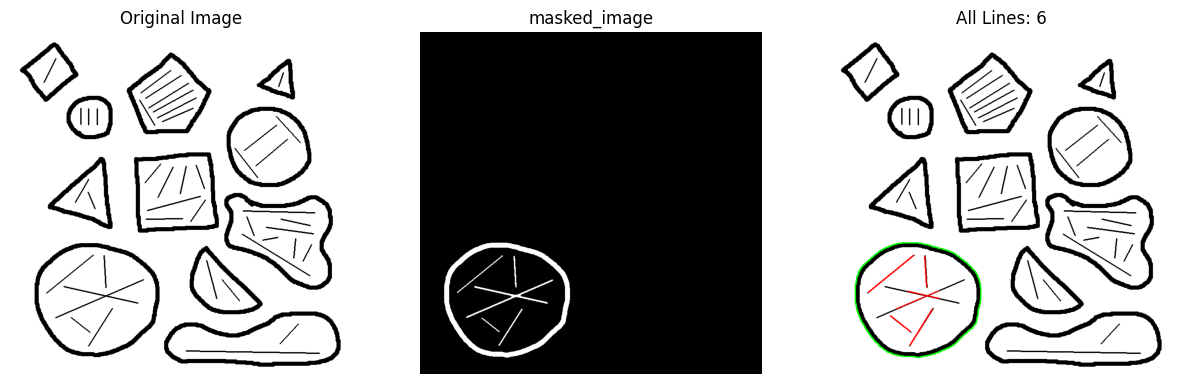

In [9]:
# Count all lines (this could be cleaner)
intersecting_lines_parameters = {
    'threshold': 35,
    'minLineLength': 40,
    'maxLineGap': 10
}

if largest is not None:
    # Get both types of lines (a bit ugly this way)
    masked_image, intersecting_lines = detect_intersecting_lines(
        image,
        largest,
        threshold_image,
        intersecting_lines_parameters
    )

    masked_image, non_intersecting_lines = detect_non_intersecting_lines(
        image,
        largest,
        threshold_image,
        non_intersecting_lines_parameters
    )

    # Calculate total number of lines
    total_lines = (len(intersecting_lines) if intersecting_lines is not None else 0) + \
                  (len(non_intersecting_lines) if non_intersecting_lines is not None else 0)

    result = draw_lines(image, largest, intersecting_lines)
    result = draw_lines(result, largest, non_intersecting_lines, swap_colors=True)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    display_results(image,
                   masked_image,
                   result,
                   'masked_image',
                   f'All Lines: {total_lines}')